# **Detecção de Fraudes em Transações Financeiras**

Luiz Henrique Rigo Faccio | CCR de `Inteligência Artifical`

*Ciência da Computação - Universidade Federal Da Fronteira Sul*

Dataset disponível em: [https://www.kaggle.com/datasets/aryan208/financial-transactions-dataset-for-fraud-detection](https://www.kaggle.com/datasets/aryan208/financial-transactions-dataset-for-fraud-detection)

## **Importando bibliotecas e o dataset**

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import datetime as dt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler

In [30]:
path = "archive/financial_fraud_detection_dataset.csv"
dataSet = pd.read_csv(path)

## **Vizualizando as informações**

In [44]:
def numeric_columns(dataSet):
    return dataSet.select_dtypes(include=['int64', 'float64']).columns
def categorical_columns(dataSet): 
    return dataSet.select_dtypes(include=['object']).columns

def analyse_target(dataSet):
    print("Target:")
    dataSet["is_fraud"].value_counts().plot(kind='bar', title='Distribuição da variável alvo')
    total = dataSet.shape[0]
    counts = dataSet["is_fraud"].value_counts()
    percentages = counts / total * 100
    for value, count in counts.items():
        print(f"Classe {value}: {count} ({percentages[value]:.4f}%)")

def analyze_data(dataSet):
    info = pd.DataFrame({"Tipos":dataSet.dtypes, "Valores únicos": dataSet.nunique(), "Valores Nulos": dataSet.isnull().sum()})
    
    print("Dimensão do dataset: ", dataSet.shape)
    display(info)

    print("Informações contínuas:")
    display(dataSet[numeric_columns(dataSet)].describe().round(3))

    if (categorical_columns(dataSet).size > 0):
        print("Informações categóricas:")
        display(dataSet[categorical_columns(dataSet)].describe().round(3))

    analyse_target(dataSet)

    print("Amostra do dataset:")
    display(dataSet.sample(5))

In [32]:
#analyze_data(dataSet)

## **Tratando os dados**

Algumas informações como IDs, tipo de fraude, números de contas e números de dispositivos são inúteis nesta situação

time_since_last_transaction tem muitos valores vazios

In [33]:
useLess = ["transaction_id", "sender_account", "receiver_account", "ip_address", "device_hash", "fraud_type", "time_since_last_transaction"]

dataSet = dataSet.drop(columns=useLess)

Para não descartar os horários das transações, eles serão agrupados em madrugada, manha, tarde e noite.

In [34]:
def categorize_timestamp(timestamps : pd.Series, int_values: bool = False) -> pd.Series:
    """Função para categorizar timestap em períodos: manhã, tarde, noite e madrugada

    Args:
        timestamps (pd.Series): Coluna de timestamp do DataSet
    
    Returns:
        periodos (pd.Series): Coluna de timestamps já categorizada
    """
    
    def get_period(hour):

        if int_values:
            return hour
        if 6 <= hour < 9:
            return "manha_1"
        if 9 <= hour < 12:
            return "manha_2"
        elif 12 <= hour < 15:
            return "tarde_1"
        elif 15 <= hour < 18:
            return "tarde_2"
        elif 18 <= hour < 21:
            return "noite_1"
        elif 18 <= hour < 21:
            return "noite_2"
        elif 21 <= hour < 23:
            return "tarde_2"
        elif 23 <= hour < 2:
            return "tarde_2"
        elif 2 <= hour < 5:
            return "madrugada_1"
        else:
            return "madrugada_2"

    periodos = timestamps.apply(lambda x: get_period(dt.datetime.fromisoformat(x).hour))
    return periodos
    

In [35]:
dataSet["timestamp"] = categorize_timestamp(dataSet["timestamp"], int_values=True)

Como não existem mais dados faltantes, não será necessário imputá-los

As informações categóricas serão tratadas com o uso de OneHotEncoding e os dados numéricos serão escalados com o uso de StandartScaler (Somente para RNA)

Os valores de y (is_fraud) serão transformados em inteiros

In [36]:
encoder = OneHotEncoder()
encoder.fit(dataSet[categorical_columns(dataSet)])
encoded_data = encoder.transform(dataSet[categorical_columns(dataSet)])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(categorical_columns(dataSet)))
dataSet = dataSet.drop(columns=categorical_columns(dataSet))
dataSet = pd.concat([dataSet, encoded_df], axis=1)

In [37]:

dtc_dataset = dataSet.copy()
dtc_dataset["is_fraud"] = dtc_dataset["is_fraud"].map(lambda x: 1 if x == True else 0)

sacaler = StandardScaler()
dataSet[numeric_columns(dataSet)] = sacaler.fit_transform(dataSet[numeric_columns(dataSet)])

dataSet["is_fraud"] = dataSet["is_fraud"].map(lambda x: 1 if x == True else 0)
rna_dataset = dataSet 


Dimensão do dataset:  (5000000, 34)


,Tipos,Valores únicos,Valores Nulos
timestamp,float64,24,0
amount,float64,217069,0
is_fraud,int64,2,0
spending_deviation_score,float64,917,0
velocity_score,float64,20,0
geo_anomaly_score,float64,101,0
transaction_type_deposit,float64,2,0
transaction_type_payment,float64,2,0
transaction_type_transfer,float64,2,0
transaction_type_withdrawal,float64,2,0


Informações contínuas:


,timestamp,amount,is_fraud,spending_deviation_score,velocity_score,geo_anomaly_score,transaction_type_deposit,transaction_type_payment,transaction_type_transfer,transaction_type_withdrawal,...,location_Tokyo,location_Toronto,device_used_atm,device_used_mobile,device_used_pos,device_used_web,payment_channel_ACH,payment_channel_UPI,payment_channel_card,payment_channel_wire_transfer
count,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,...,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000,5000000.000
mean,-0.000,0.000,0.036,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,...,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000
std,1.000,1.000,0.186,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-1.661,-0.764,0.000,-5.255,-1.648,-1.732,-0.578,-0.577,-0.577,-0.577,...,-0.378,-0.378,-0.577,-0.578,-0.577,-0.577,-0.577,-0.577,-0.577,-0.578
25%,-0.939,-0.707,0.000,-0.679,-0.954,-0.866,-0.578,-0.577,-0.577,-0.577,...,-0.378,-0.378,-0.577,-0.578,-0.577,-0.577,-0.577,-0.577,-0.577,-0.578
50%,-0.072,-0.469,0.000,0.000,0.086,-0.000,-0.578,-0.577,-0.577,-0.577,...,-0.378,-0.378,-0.577,-0.578,-0.577,-0.577,-0.577,-0.577,-0.577,-0.578
75%,0.795,0.308,0.000,0.670,0.953,0.866,1.732,1.732,1.732,-0.577,...,-0.378,-0.378,-0.577,1.731,-0.577,1.732,1.732,-0.577,-0.577,1.731
max,1.662,6.728,1.000,5.016,1.647,1.732,1.732,1.732,1.732,1.733,...,2.643,2.647,1.732,1.731,1.733,1.732,1.732,1.733,1.732,1.731


Target:
Classe 0: 4820447 (96.4089%)
Classe 1: 179553 (3.5911%)
Amostra do dataset:


,timestamp,amount,is_fraud,spending_deviation_score,velocity_score,geo_anomaly_score,transaction_type_deposit,transaction_type_payment,transaction_type_transfer,transaction_type_withdrawal,...,location_Tokyo,location_Toronto,device_used_atm,device_used_mobile,device_used_pos,device_used_web,payment_channel_ACH,payment_channel_UPI,payment_channel_card,payment_channel_wire_transfer
2179462,-1.227605,-0.139901,0,0.120291,-1.300767,-0.381206,1.731503,-0.577485,-0.577453,-0.576930,...,2.643350,-0.377739,1.732383,-0.577699,-0.577091,-0.577372,-0.577424,-0.576995,-0.577256,1.730925
4161709,0.506166,-0.667551,0,0.070331,-1.300767,-1.593810,-0.577533,1.731646,-0.577453,-0.576930,...,2.643350,-0.377739,1.732383,-0.577699,-0.577091,-0.577372,-0.577424,-0.576995,1.732334,-0.577726
2203185,0.506166,0.233130,0,0.679840,-0.086931,0.450295,-0.577533,-0.577485,-0.577453,1.733313,...,-0.378308,-0.377739,-0.577239,-0.577699,1.732829,-0.577372,-0.577424,-0.576995,-0.577256,1.730925
998414,-0.649681,0.501679,0,-0.519193,-0.953957,-1.212706,1.731503,-0.577485,-0.577453,-0.576930,...,-0.378308,-0.377739,-0.577239,-0.577699,-0.577091,1.731985,-0.577424,-0.576995,-0.577256,1.730925
4117638,-0.216238,1.491415,0,0.320130,0.606689,0.623524,1.731503,-0.577485,-0.577453,-0.576930,...,-0.378308,2.647327,-0.577239,-0.577699,1.732829,-0.577372,-0.577424,-0.576995,-0.577256,1.730925


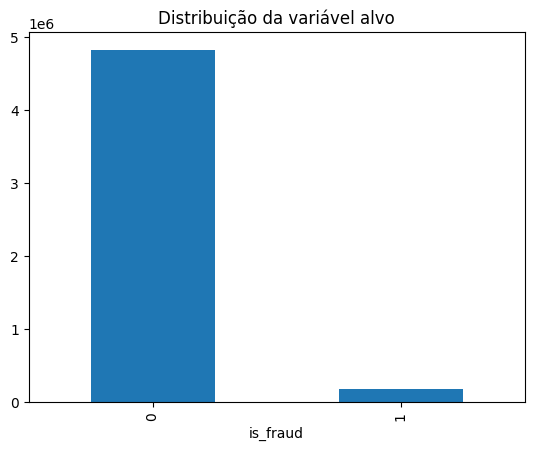

In [38]:
analyze_data(rna_dataset)

## **Ajustando classes**

É facilmente identificável a imparidade no número de amostras de cada classe.
Isso pode implicar em severas consequências na sensibilidade e habilidade de generalização dos modelos treinados

Apesar da discrepância relativa ser grande, o número absoluto de amostras da classe menos frequente (`is_fraud == 1`) é significativo: 179553

Desta forma, para resolver o problema, será realizado um *undersampling* da classe dominante. Isto é, remover um número de amostras da classe dominante para que ambas classes possuam valores similares de exemplos

Target:
Classe 0: 179553 (50.0000%)
Classe 1: 179553 (50.0000%)


,timestamp,amount,is_fraud,spending_deviation_score,velocity_score,geo_anomaly_score,transaction_type_deposit,transaction_type_payment,transaction_type_transfer,transaction_type_withdrawal,...,location_Tokyo,location_Toronto,device_used_atm,device_used_mobile,device_used_pos,device_used_web,payment_channel_ACH,payment_channel_UPI,payment_channel_card,payment_channel_wire_transfer
1336816,15,44.86,1,2.06,11,0.96,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


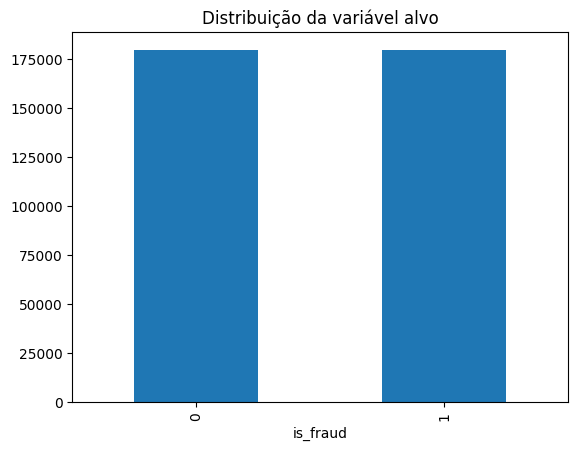

In [ ]:
undersampler = RandomUnderSampler(random_state=42)
rna_resampled, _ = undersampler.fit_resample(rna_dataset, rna_dataset["is_fraud"])
dtc_resampled, _ = undersampler.fit_resample(dtc_dataset, dtc_dataset["is_fraud"])

analyse_target(dtc_resampled)
dtc_resampled.sample(5)

## **Treinando Modelos**

Separando os dados de treino e de teste

Realizando ao treinamento dos modelos

In [48]:
X_train_rna, X_test_rna, y_train_rna, y_test_rna = train_test_split(rna_resampled.drop(columns=["is_fraud"]), rna_resampled["is_fraud"], test_size=0.2, random_state=42)
X_train_dtc, X_test_dtc, y_train_dtc, y_test_dtc = train_test_split(dtc_resampled.drop(columns=["is_fraud"]), dtc_resampled["is_fraud"], test_size=0.2, random_state=42)

# Decision Tree Classifier with values not scaled
dt_classifier_unscaled = DecisionTreeClassifier(
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
)
dt_classifier_unscaled.fit(X_train_dtc, y_train_dtc)
print("Decision Tree Classifier Score: ", dt_classifier_unscaled.score(X_test_dtc, y_test_dtc))

# Decision Tree Classifier with scaled values
dt_classifier_scaled = DecisionTreeClassifier(
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
)
dt_classifier_scaled.fit(X_train_rna, y_train_rna)
print("Decision Tree Classifier Score: ", dt_classifier_scaled.score(X_test_rna, y_test_rna))

# Neural Network Classifier
nn_classifier = MLPClassifier(
    hidden_layer_sizes=(34, 100, 150, 50, 2),
    activation='relu',
    solver='adam',
    max_iter=300,
    learning_rate_init=0.001,
)
nn_classifier.fit(X_train_rna, y_train_rna)
print("Neural Network Classifier Score: ", nn_classifier.score(X_test_rna, y_test_rna))

Decision Tree Classifier Score:  0.4985519757177467
Decision Tree Classifier Score:  0.49857982233855924


C:\Users\Pichau\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Neural Network Classifier Score:  0.49722926122914984


Decision Tree Classifier (Unscaled) Results:
Accuracy: 0.4985519757177467
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.52      0.51     36067
           1       0.50      0.48      0.49     35755

    accuracy                           0.50     71822
   macro avg       0.50      0.50      0.50     71822
weighted avg       0.50      0.50      0.50     71822



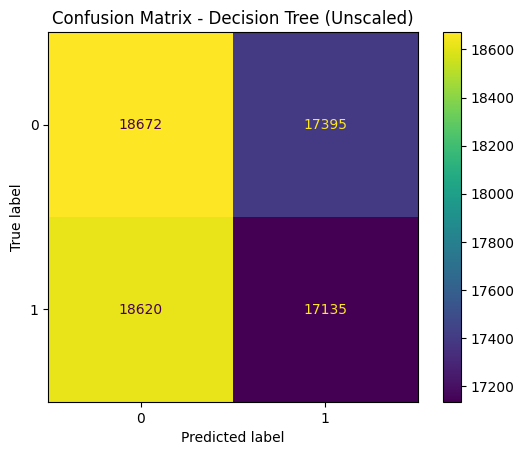

Decision Tree Classifier (Scaled) Results:
Accuracy: 0.49857982233855924
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.52      0.51     36067
           1       0.50      0.48      0.49     35755

    accuracy                           0.50     71822
   macro avg       0.50      0.50      0.50     71822
weighted avg       0.50      0.50      0.50     71822



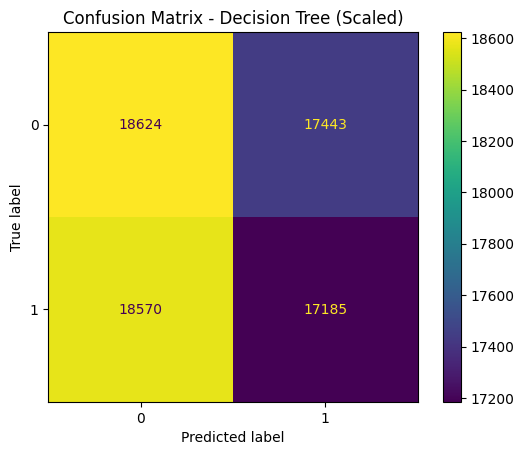

Neural Network Classifier Results:
Accuracy: 0.49722926122914984
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.38      0.43     36067
           1       0.50      0.62      0.55     35755

    accuracy                           0.50     71822
   macro avg       0.50      0.50      0.49     71822
weighted avg       0.50      0.50      0.49     71822



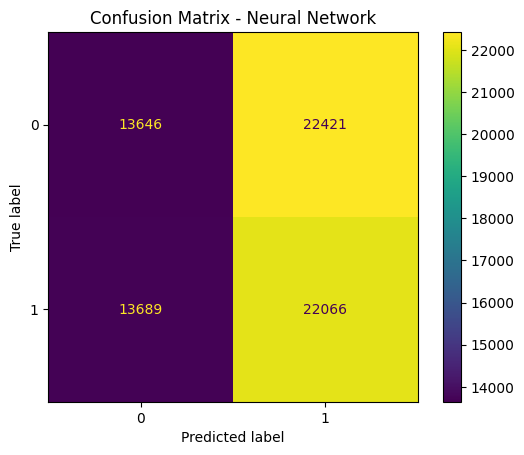

In [49]:
# Decision Tree Classifier (Unscaled)
print("Decision Tree Classifier (Unscaled) Results:")
y_pred_dtc_unscaled = dt_classifier_unscaled.predict(X_test_dtc)
print("Accuracy:", accuracy_score(y_test_dtc, y_pred_dtc_unscaled))
print("Classification Report:\n", classification_report(y_test_dtc, y_pred_dtc_unscaled))
ConfusionMatrixDisplay.from_predictions(y_test_dtc, y_pred_dtc_unscaled)
plt.title("Confusion Matrix - Decision Tree (Unscaled)")
plt.show()

# Decision Tree Classifier (Scaled)
print("Decision Tree Classifier (Scaled) Results:")
y_pred_dtc_scaled = dt_classifier_scaled.predict(X_test_rna)
print("Accuracy:", accuracy_score(y_test_rna, y_pred_dtc_scaled))
print("Classification Report:\n", classification_report(y_test_rna, y_pred_dtc_scaled))
ConfusionMatrixDisplay.from_predictions(y_test_rna, y_pred_dtc_scaled)
plt.title("Confusion Matrix - Decision Tree (Scaled)")
plt.show()

# Neural Network Classifier
print("Neural Network Classifier Results:")
y_pred_nn = nn_classifier.predict(X_test_rna)
print("Accuracy:", accuracy_score(y_test_rna, y_pred_nn))
print("Classification Report:\n", classification_report(y_test_rna, y_pred_nn))
ConfusionMatrixDisplay.from_predictions(y_test_rna, y_pred_nn)
plt.title("Confusion Matrix - Neural Network")
plt.show()